# Fitting STRFs from a Data object

This tutorial shows some of the basics of fitting STRFs and getting their predictions for neural data in a Data object.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample

import naplib as nl

In [2]:
data = nl.io.load_speech_task_data()

In [3]:
# This data contains the fields 'aud' and 'resp', which give the stimulus and neural responses
print(f"aud stimulus shape for first trial : {data[0]['aud'].shape}")
print(f"response shape for first trial : {data[0]['resp'].shape}")

aud stimulus shape for first trial : (6197, 128)
response shape for first trial : (6197, 10)


In [4]:
data.fields

['name',
 'sound',
 'soundf',
 'dataf',
 'duration',
 'befaft',
 'resp',
 'aud',
 'script']

In [5]:
# get auditory spectrogram for each stimulus sound
data['spec'] = [nl.features.auditory_spectrogram(trial['sound'], 11025) for trial in data]

# make sure the spectrogram is the exact same size as the responses
data['spec'] = [resample(trial['spec'], trial['resp'].shape[0]) for trial in data] 

# Since the spectrogram is 128-channels, which is very large, we downsample it
print(f"before resampling: {data['spec'][0].shape}")

resample_kwargs = {'num': 32, 'axis': 1}
data['spec_32'] = nl.array_ops.concat_apply(data['spec'], resample, function_kwargs=resample_kwargs)

print(f"after resampling:  {data['spec_32'][0].shape}")


before resampling: (6197, 128)
after resampling:  (6197, 32)


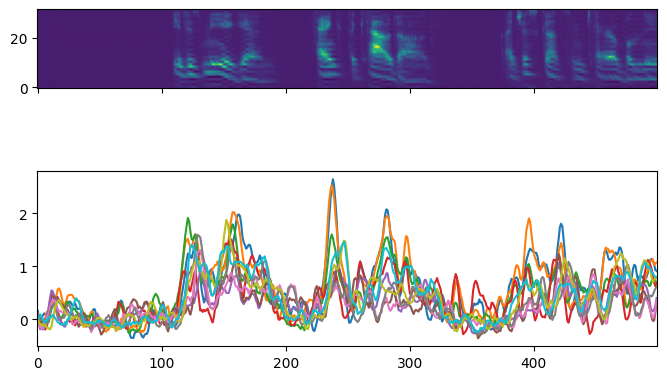

In [6]:
# Let's look at the first 5 seconds more closely to understand the data

fig, axes = plt.subplots(2,1,figsize=(8,5), sharex=True)
axes[0].imshow(data[0]['spec_32'][:500].T, aspect=2, origin='lower')

axes[1].plot(data[0]['resp'][:500])

plt.show()

## Fit STRFs

Fit STRF models that have a receptive field of 300 ms in the past

In [7]:
tmin = 0 # receptive field begins at time=0
tmax = 0.3 # receptive field ends at a lag of 0.4 seconds
sfreq = 100 # sampling frequency of data

# For the sake of the cleanliness of this notebook, we set verbose=1
# Setting verbose=2 would print lots of information
# about the cross-validation procedure while the STRFs are being computed,
# and verbose=0 would print nothing during fitting
strf_model = nl.encoding.TRF(tmin, tmax, sfreq, verbose=1)


In [8]:
# first, we normalize the responses
data['resp'] = nl.preprocessing.normalize(data=data, field='resp')

In [9]:
# train model on the first 9 trials 
data_train = data[:-1]
data_test = data[-1:]

### Fit STRFs with L2 regularization (default model params)

- Ridge regularization, default set of alphas

In [10]:
# Now, fit the model to the training data. This model will contain
# 10 STRFs, one for each output channel in resp

strf_model.fit(data=data_train, X='spec_32', y='resp')


  0%|          | 0/10 [00:00<?, ?it/s]

TRF(estimator=RidgeCV(alphas=array([1.00000000e-02, 3.16227766e-01, 1.00000000e+01, 3.16227766e+02,
       1.00000000e+04]),
                      cv=5),
    sfreq=100.0, tmax=0.3, tmin=0)

### Fit STRFs with ElasticNet estimator

- Combination of L1 and L2 regularization
- Use the cross-validated ElasticNet model from sklearn and cross-validate over alphas

In [11]:
from sklearn.linear_model import ElasticNetCV

In [12]:
# define the estimator to be used in this TRF model
estimator = ElasticNetCV(l1_ratio=0.5, alphas=np.logspace(-2,4,5))

strf_model_2 = nl.encoding.TRF(tmin, tmax, sfreq, estimator=estimator, verbose=1)
strf_model_2.fit(data=data_train, X='spec_32', y='resp')


  0%|          | 0/10 [00:00<?, ?it/s]

TRF(estimator=ElasticNetCV(alphas=array([1.00000000e-02, 3.16227766e-01, 1.00000000e+01, 3.16227766e+02,
       1.00000000e+04])),
    sfreq=100.0, tmax=0.3, tmin=0)

## Analyze the STRFs

In [13]:
# compute correlation scores for the withheld test data

scores = strf_model.score(data=data_test, X='spec_32', y='resp')
scores_2 = strf_model_2.score(data=data_test, X='spec_32', y='resp')

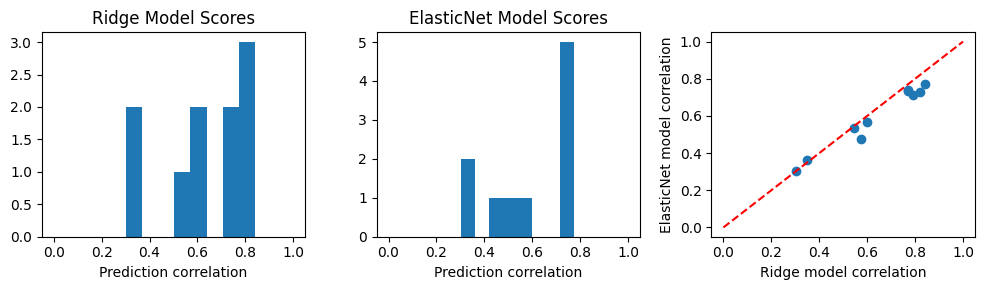

In [14]:
# compare the scores from each model's predictions

fig, axes = plt.subplots(1,3,figsize=(10,3), sharex=True)
axes[0].hist(scores, 8)
axes[0].set_xlabel('Prediction correlation')
axes[0].set_title('Ridge Model Scores')
axes[1].hist(scores_2, 8)
axes[1].set_xlabel('Prediction correlation')
axes[1].set_title('ElasticNet Model Scores')
axes[2].scatter(scores, scores_2)
axes[2].set_xlabel('Ridge model correlation')
axes[2].set_ylabel('ElasticNet model correlation')
axes[2].plot([0,1],[0,1],'r--')
plt.tight_layout()
plt.show()


In [16]:
# we can access the STRF weights through the .coef_ attribute of the model
coef_ridge = strf_model.coef_
coef_elastic = strf_model_2.coef_

print(f'STRF shape (num_outputs, frequency, lag) = {coef_ridge.shape}')


STRF shape (num_outputs, frequency, lag) = (10, 32, 31)


### Visualize the STRF for each electrode

We can see that the ElasticNet model gives a sparser STRF

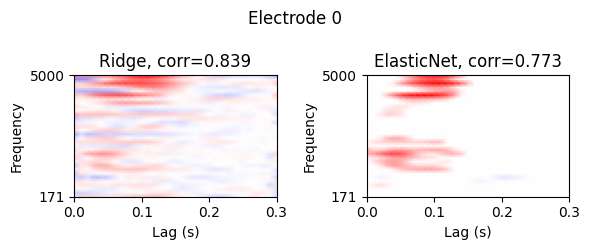

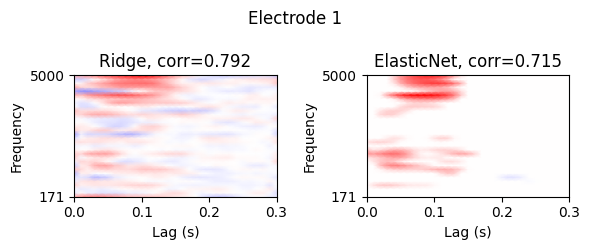

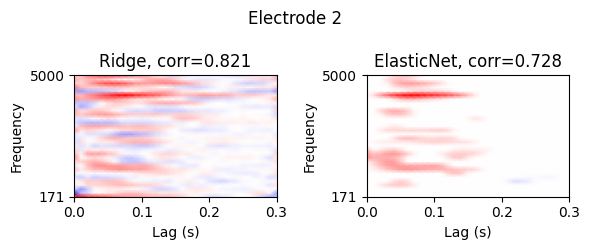

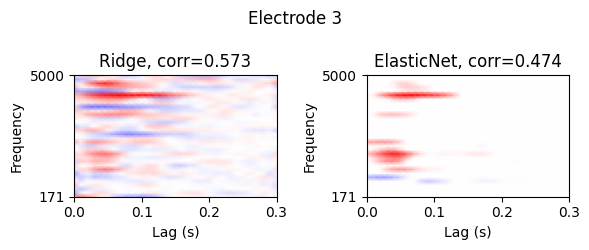

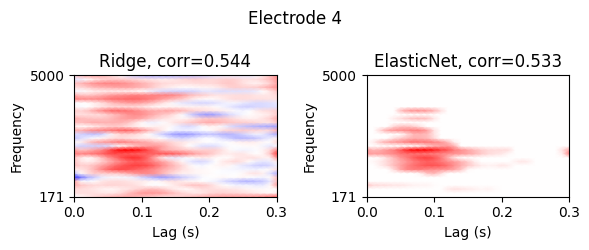

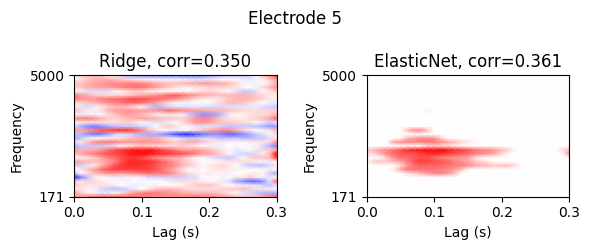

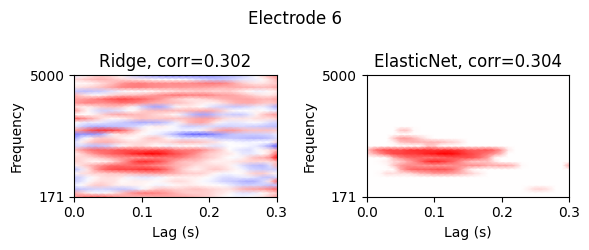

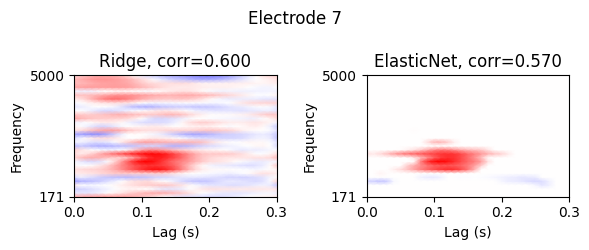

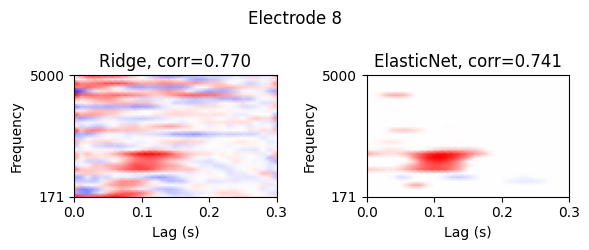

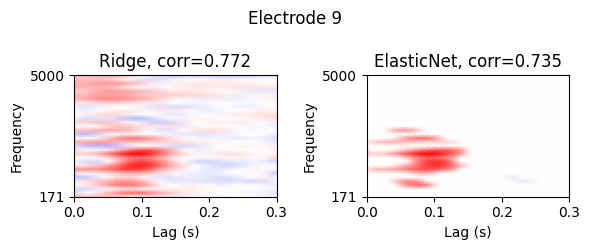

In [17]:
# Now, visualize the STRF weights for each electrode and for each model
from naplib.visualization import imSTRF


freqs = [171, 5000]

for elec, (model_1_coef, model_2_coef, score_model_1, score_model_2) in enumerate(zip(coef_ridge, coef_elastic, scores, scores_2)):
    fig, axes = plt.subplots(1,2,figsize=(6,2.5))
    imSTRF(model_1_coef, tmin=tmin, tmax=tmax, freqs=freqs, ax=axes[0])
    axes[0].set_title('Ridge, corr={:2.3f}'.format(score_model_1))
    imSTRF(model_2_coef, tmin=tmin, tmax=tmax, freqs=freqs, ax=axes[1])
    axes[1].set_title('ElasticNet, corr={:2.3f}'.format(score_model_2))
    fig.suptitle(f'Electrode {elec}')
    fig.tight_layout()
    plt.show()
    
    

### Compute and plot STRF predictions

We see that the two STRF models have nearly identical predictions for most electrodes

In [18]:
predictions = strf_model.predict(data=data_test, X='spec_32') # this is a list of the same length as data_test
predictions_2 = strf_model_2.predict(data=data_test, X='spec_32')

# shapes of predictions for each test trial 
print([x.shape for x in predictions])

[(5621, 10)]


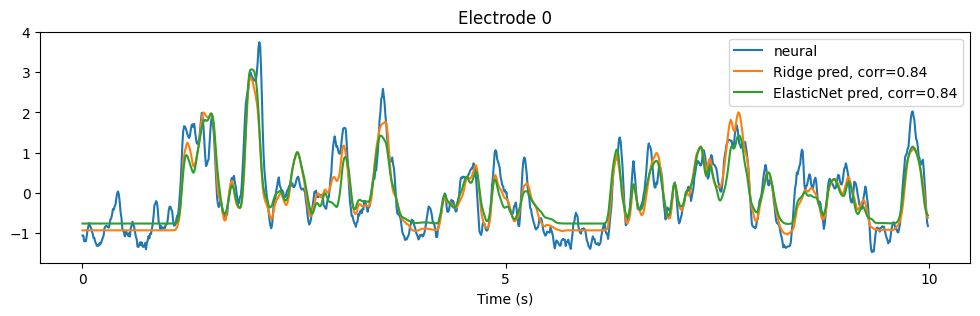

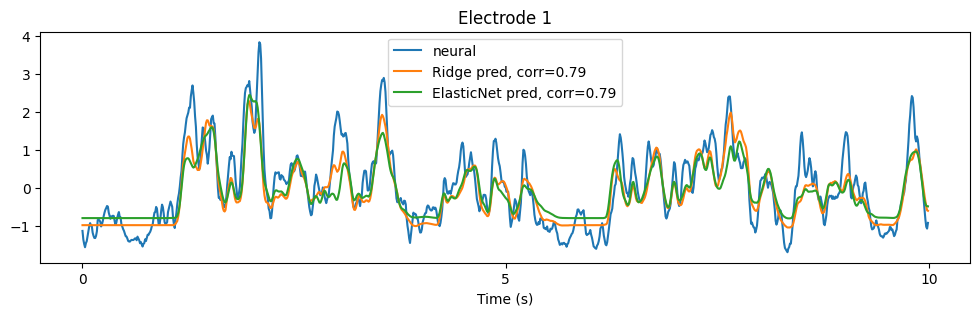

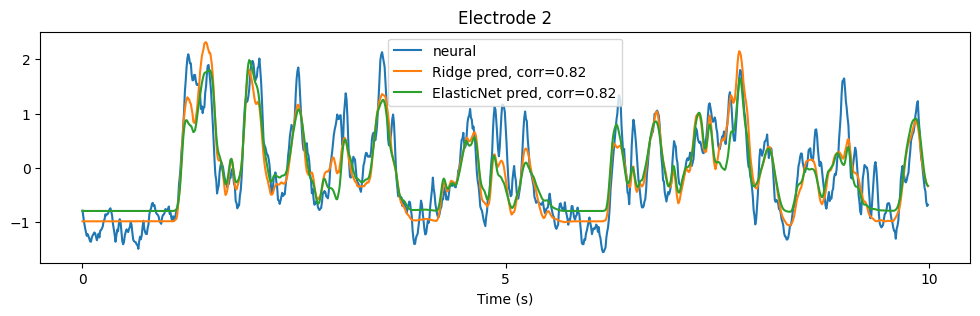

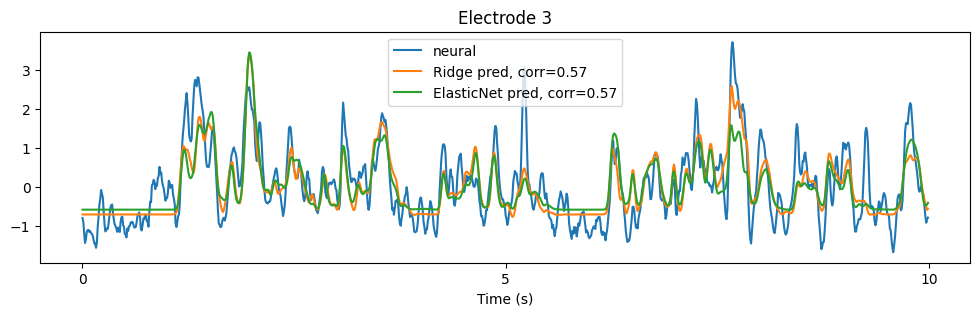

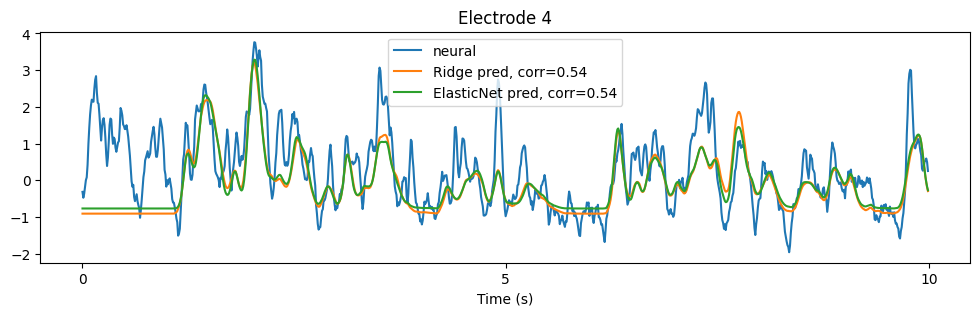

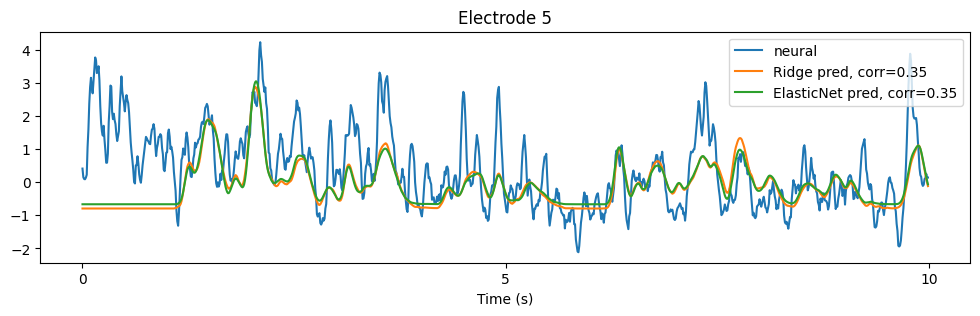

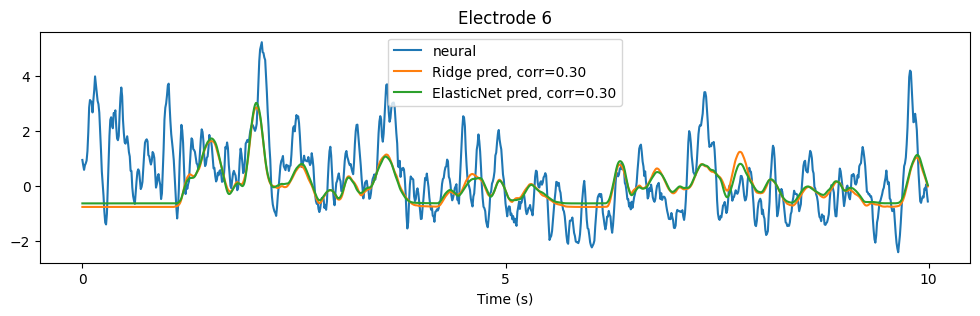

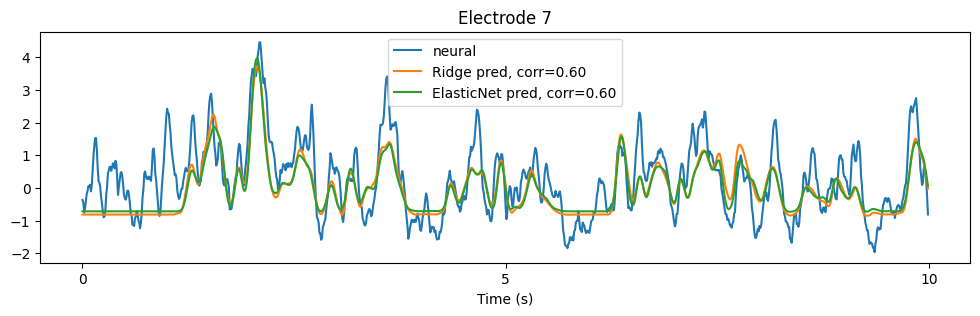

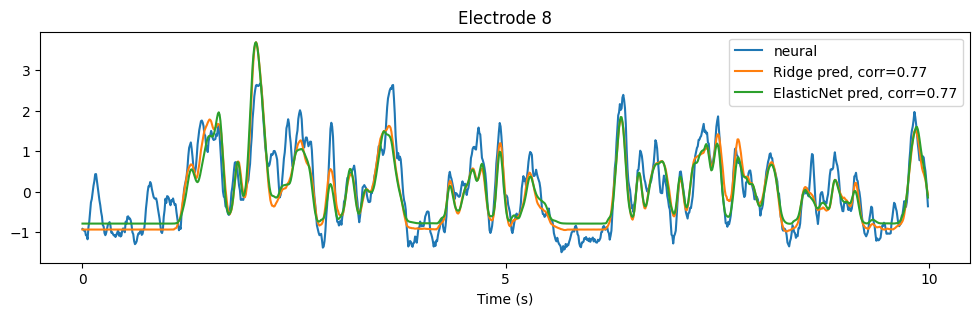

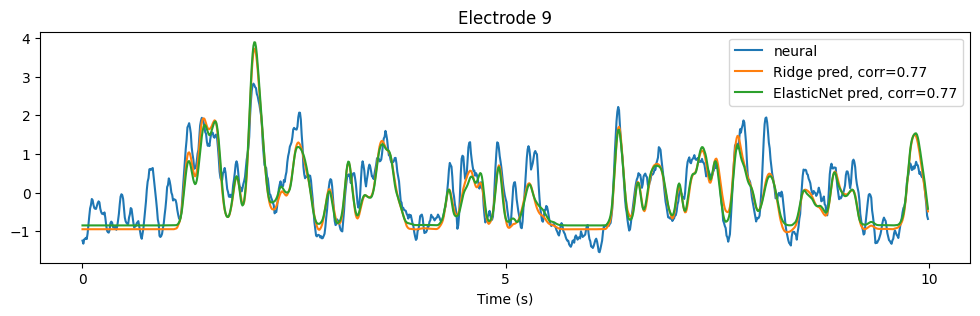

In [19]:
# plot the predictions for the first 10 seconds of the final trial for each electrode

for elec in range(predictions[0].shape[1]):

    plt.figure(figsize=(12,3))
    plt.plot(data_test['resp'][-1][:1000,elec], label='neural')
    plt.plot(predictions[-1][:1000,elec], label='Ridge pred, corr={:2.2f}'.format(scores[elec]))
    plt.plot(predictions_2[-1][:1000,elec], label='ElasticNet pred, corr={:2.2f}'.format(scores[elec]))
    plt.xticks([0, 500, 1000], ['0', '5', '10'])
    plt.xlabel('Time (s)')
    plt.legend()
    plt.title(f'Electrode {elec}')
    plt.show()


